# Setup

Perform all necessary imports up front

In [ ]:
!pip install --quiet armory-library armory-examples[cv]

In [ ]:
%matplotlib inline

import matplotlib.pyplot
import torch
import torchmetrics.utilities.plot
from IPython.display import display

# armory-library imports
import armory.engine
import armory.evaluation
import armory.results

# armory-examples imports
import armory.examples.image_classification.food101 as food101

# Define the evaluation

We will only care about the following classes, so the dataset will be filtered:
  - beignets
  - churros
  - donuts

In [ ]:
only_class_names = ["beignets", "churros", "donuts"]

evaluation = armory.evaluation.Evaluation(
    name="image-classification-food101-xai",
    description="Image classification of food-101 with explainability outputs",
    author="TwoSix",
)

with evaluation.autotrack():
    model, art_estimator = food101.load_model()
evaluation.use_model(model)

with evaluation.autotrack():
    dataset, labels = food101.load_huggingface_dataset(
        batch_size=8,
        shuffle=True,
        seed=8675309,
        only_classes=only_class_names,
    )
evaluation.use_dataset(dataset)

only_class_names.append("spring_rolls")
only_classes = [labels.index(c) for c in only_class_names]

with evaluation.autotrack():
    pgd = food101.create_pgd_attack(art_estimator)

with evaluation.autotrack():
    compression = food101.create_compression_defence()

evaluation.use_metrics(food101.create_metrics())

evaluation.use_exporters(
    food101.create_exporters(
        model,
        export_every_n_batches=1,
        saliency_classes=only_classes
    )
)

with evaluation.add_chain("benign"):
    pass

with evaluation.add_chain("pgd") as chain:
    chain.add_perturbation(pgd)

with evaluation.add_chain("defended") as chain:
    chain.add_perturbation(pgd)
    chain.add_perturbation(compression)

engine = armory.engine.EvaluationEngine(
    evaluation,
    limit_test_batches=1,
)

# Run the evaluation

In [ ]:
results = engine.run()
# Or, to load results from a previous run:
# results = armory.results.EvaluationResults.for_last_run(experiment_name=evaluation.name)
chains = [
    results.children["benign"],
    results.children["pgd"],
    results.children["defended"],
]
titles = ["Benign", "PGD", "Defended"]

# Metrics & Parameters

In [ ]:
armory.results.plot_metrics(*chains, blacklist=["epoch"])

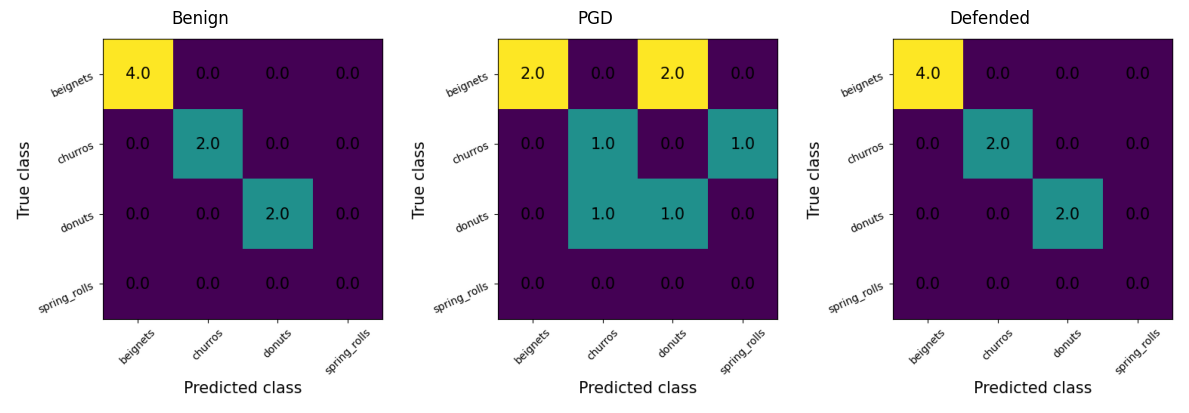

In [ ]:
with matplotlib.pyplot.ioff():
    conf_matrices = []
    for chain in chains:
        cm = torch.tensor(chain.artifacts["metrics/confusion_matrix.txt"].json)
        cm = cm[only_classes][:, only_classes]
        conf_matrices.append(
            torchmetrics.utilities.plot.plot_confusion_matrix(cm, labels=only_class_names)[0]
        )

armory.results.plot_in_grid(
    conf_matrices,
    columns=titles,
    figsize=(12, 12),
)

In [ ]:
armory.results.plot_params(*chains)

# Batch samples

In [ ]:
batch_num = 0
sample_nums = [1, 3, 4, 6]

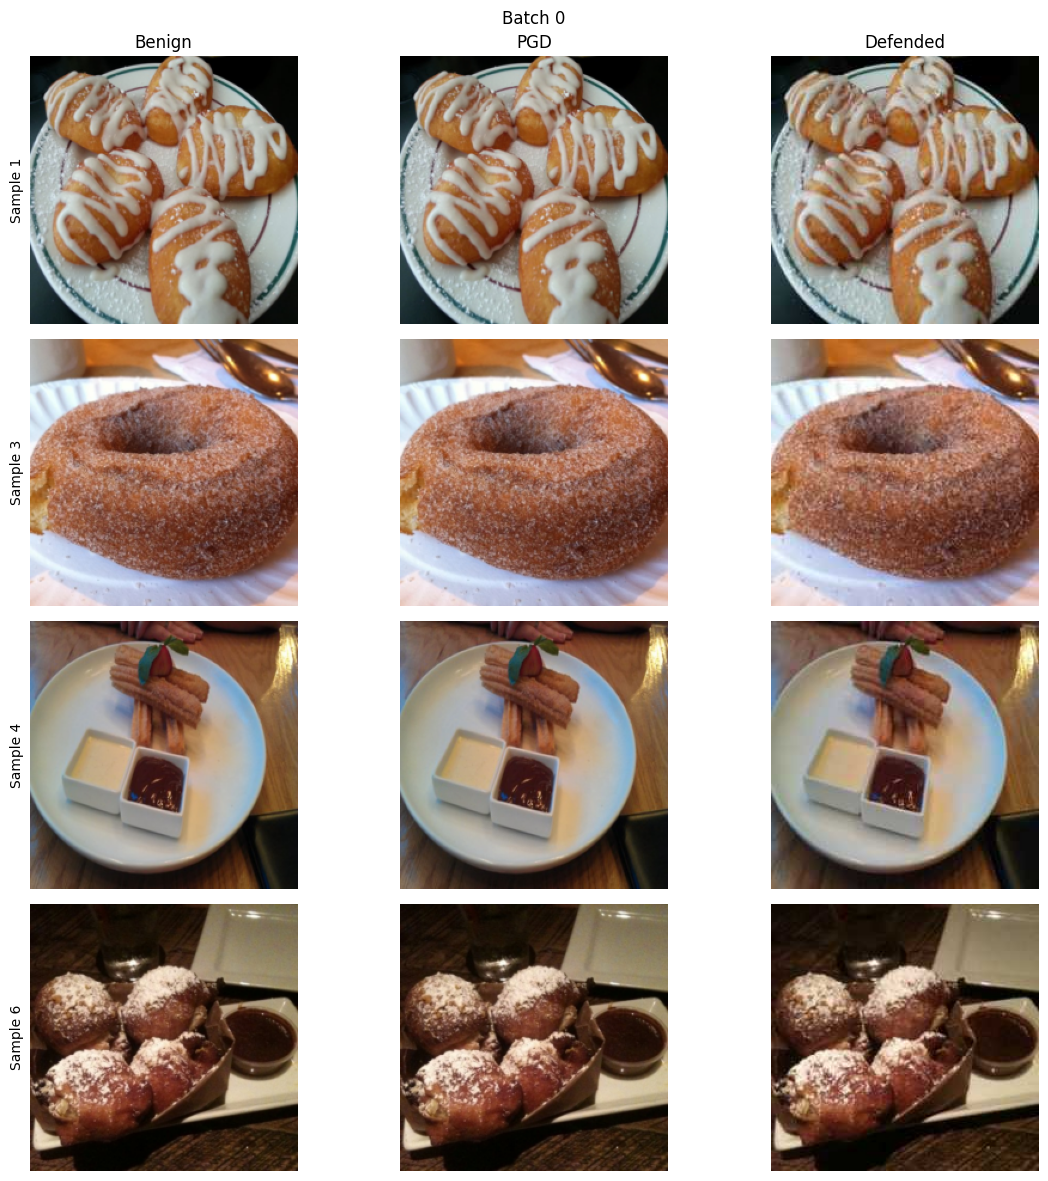

In [ ]:
armory.results.plot_in_grid(
    [
        [
            chain.batch(batch_num).sample(i)["input.png"].image
            for chain in chains
        ]
        for i in sample_nums
    ],
    columns=titles,
    figsize=(12, 12),
    rows=[f"Sample {i}" for i in sample_nums],
    title="Batch 0",
)

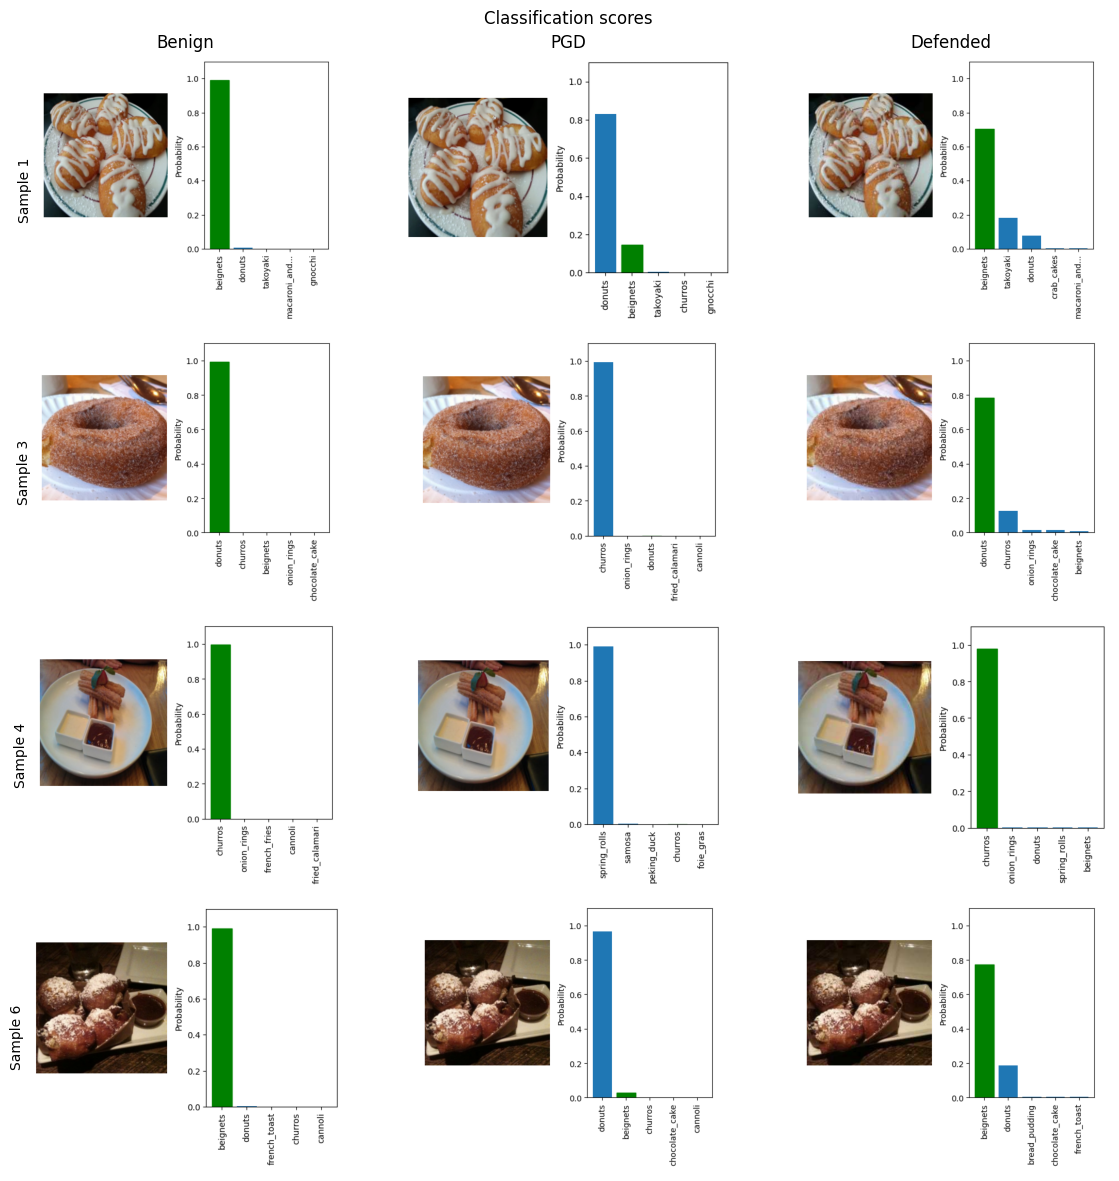

In [ ]:
armory.results.plot_in_grid(
    [
        [
            chain.batch(batch_num).sample(i).classification.plot(labels=labels, top_k=5)
            for chain in chains
        ]
        for i in sample_nums
    ],
    columns=titles,
    figsize=(12, 12),
    rows=[f"Sample {i}" for i in sample_nums],
    title="Classification scores",
)

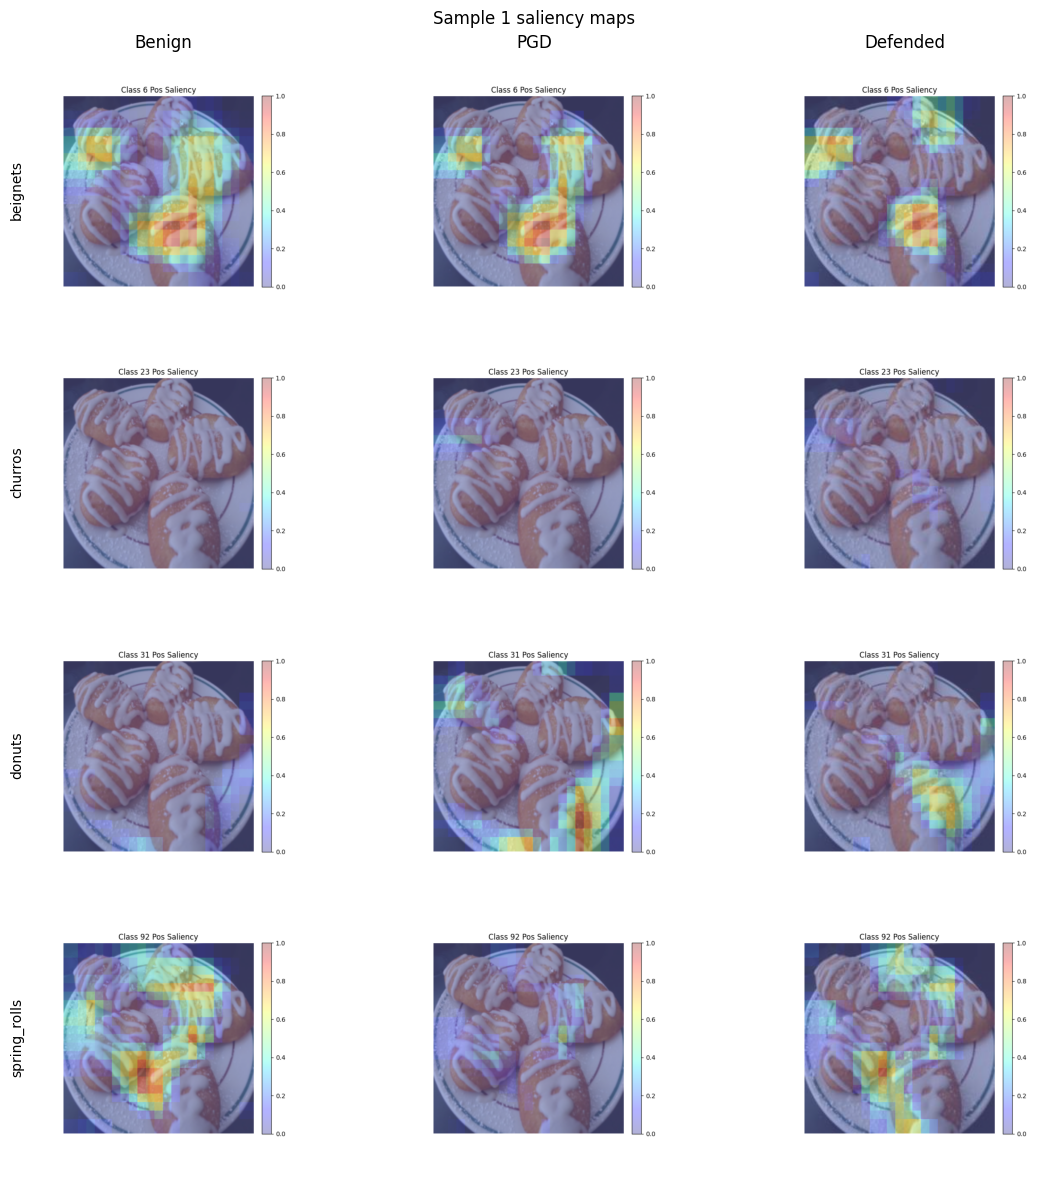

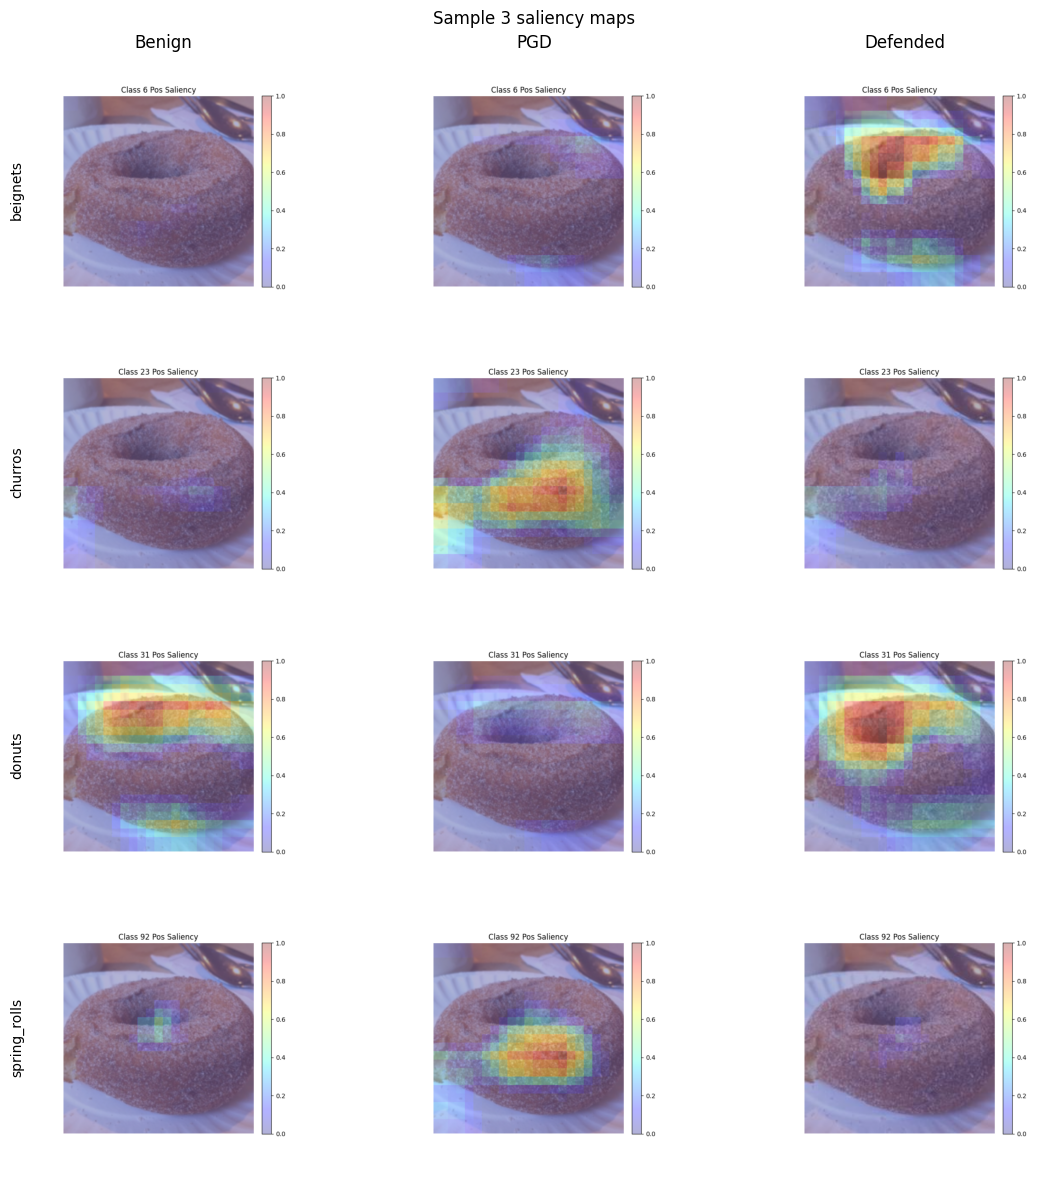

/home/kyle-treubig/Code/armory/armory-library/library/src/armory/results/plots.py:66: RuntimeWarning: More than 20 figures have been opened. Figures created through the pyplot interface (`matplotlib.pyplot.figure`) are retained until explicitly closed and may consume too much memory. (To control this warning, see the rcParam `figure.max_open_warning`). Consider using `matplotlib.pyplot.close()`.
  figure = plt.figure(figsize=figsize)


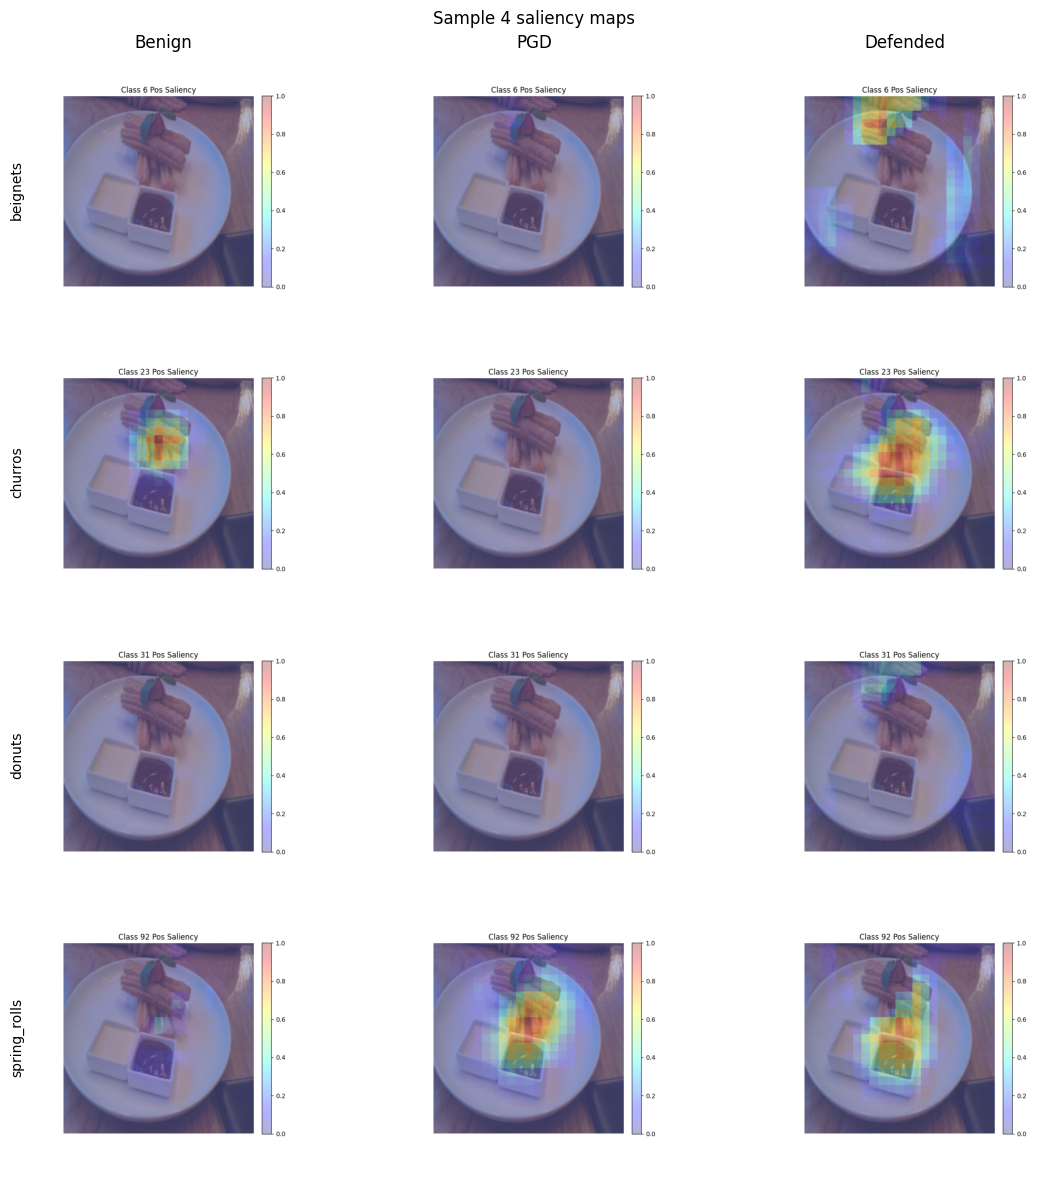

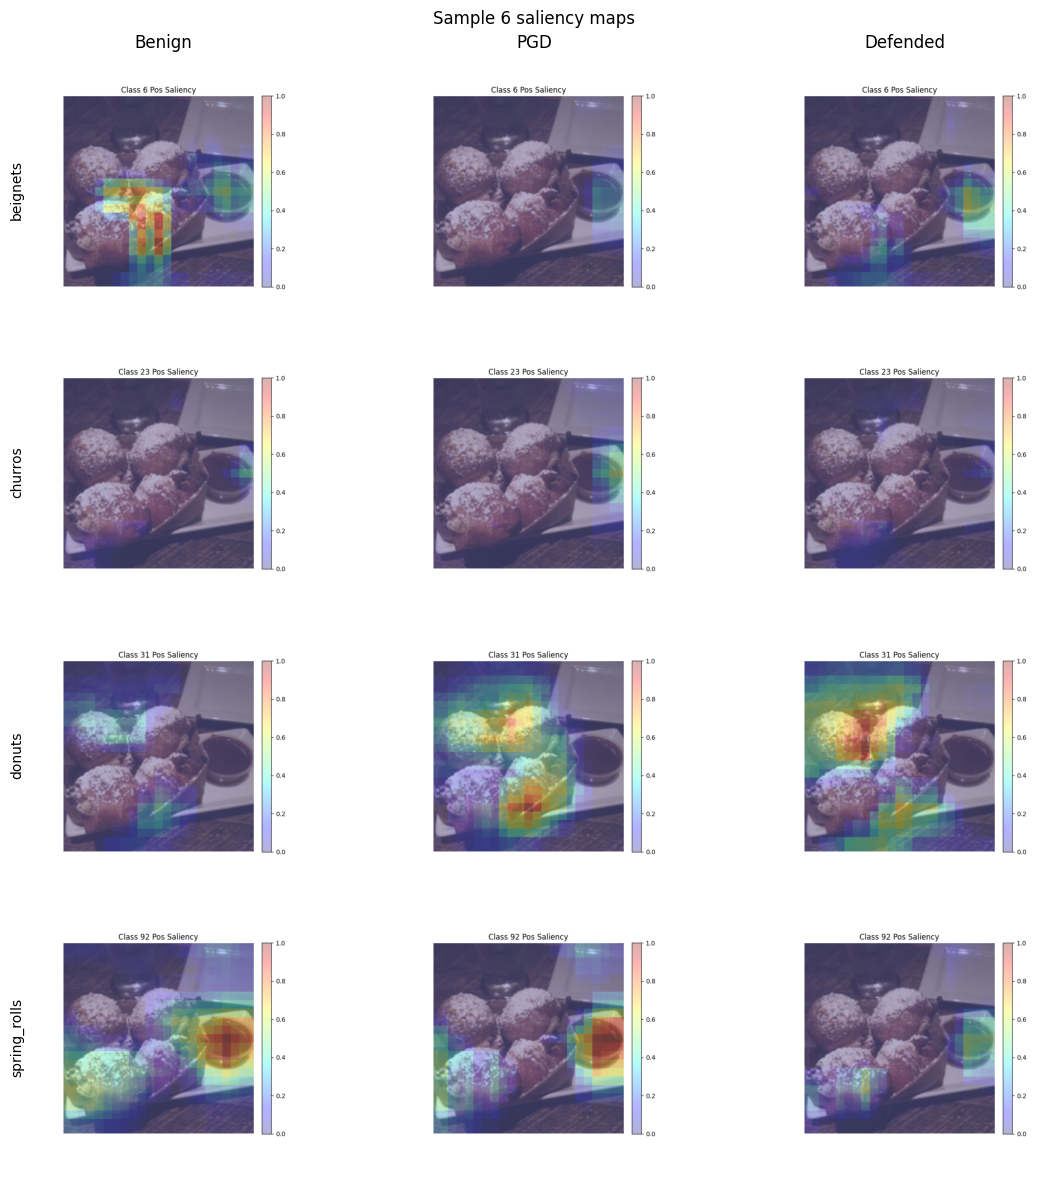

In [ ]:
for sample_num in sample_nums:
    fig = armory.results.plot_in_grid(
        [
            [
                chain.batch(batch_num).sample(sample_num)[f"xaitk_saliency_slidingwindow_{saliency_class}_pos.png"].image
                for chain in chains
            ]
            for saliency_class in only_classes
        ],
        columns=titles,
        figsize=(12, 12),
        rows=[labels[saliency_class] for saliency_class in only_classes],
        title=f"Sample {sample_num} saliency maps",
    )
    display(fig)